## 1. Imports and Libraries

 This section includes all the necessary libraries for loading and processing the data, defining the model, training, and evaluating the results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt


c:\Users\ASUS\miniconda3\envs\new_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Download Dataset

Here, you use kagglehub to download the FER-2013 dataset, which contains facial emotion images.

In [2]:
# Download dataset
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

# Dataset paths
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")


Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\msambare\fer2013\versions\1


## 3. Device Configuration

This section sets the device for training (GPU if available, else CPU).

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 4. Classes (Emotion Labels)

This section loads the list of emotion labels from the dataset.

In [4]:
# Classes
classes = os.listdir(train_path)


## 5. Data Preprocessing and Augmentation

Defines the transformations to apply to the images, such as resizing, random rotation, color jitter, etc., for both training and testing datasets.

In [5]:
# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


## 6. Dataset and DataLoader

Here, the datasets are loaded from the directories, and a WeightedRandomSampler is used to handle class imbalance. The datasets are wrapped in DataLoader objects for efficient batching during training.

In [6]:
# Load datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

# Handle class imbalance using WeightedRandomSampler
class_counts = [len([img for img, label in train_dataset.samples if label == i]) for i in range(len(classes))]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


## 7. Loss Function: Focal Loss

Defines a custom loss function called FocalLoss, which is useful for addressing class imbalance.

In [7]:
# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return F_loss


## 8. Model Definition

This section initializes a pre-trained EfficientNet-B0 model and customizes the classifier layer to match the number of classes in the dataset.

In [8]:
# Initialize EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Added dropout for regularization
    nn.Linear(model.classifier[1].in_features, len(classes))
)
model = model.to(device)

# Unfreeze more layers for better fine-tuning
for param in model.features[3:].parameters():
    param.requires_grad = True


c:\Users\ASUS\miniconda3\envs\new_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\new_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 9. Optimizer and Scheduler

Defines the optimizer (Adam) and a learning rate scheduler (ReduceLROnPlateau) to adjust the learning rate during training based on validation loss.

In [9]:
# Loss and optimizer
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


## 10. Training Function

The train_model function performs the training loop, which includes both training and validation phases. It also implements early stopping and model saving based on validation performance.

In [10]:
import os

# Path to the saved model file
model_path = 'best_model_1_state.pth'

def train_model(model, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_val_loss = float('inf')
    best_val_acc = 0
    trigger_times = 0

    # Check if the model already exists and load it
    if os.path.exists(model_path):
        print("Loading pre-trained model...")
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set the model to evaluation mode to prevent training during loading
        return model  # Return the pre-trained model if already exists
    
    # If no pre-trained model, proceed with training
    print("Training the model from scratch...")
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = train_correct / total
        train_loss /= total

        model.eval()
        val_loss, val_correct, total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = val_correct / total
        val_loss /= total

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # Save the model if both validation accuracy and loss improve
        if val_loss < best_val_loss and val_acc > best_val_acc:
            print(f"Validation improved. Saving model at epoch {epoch+1}")
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            trigger_times = 0  # Reset patience counter
        else:
            trigger_times += 1

        # Early stopping
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return model


## 11. Model Training

This section actually trains the model by calling the train_model function.

In [11]:
# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20, patience=5)


Loading pre-trained model...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_57720\3122908472.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## 12. Confusion Matrix Evaluation

After training, the model is evaluated on the test set, and a confusion matrix is displayed to assess its performance on the different classes.

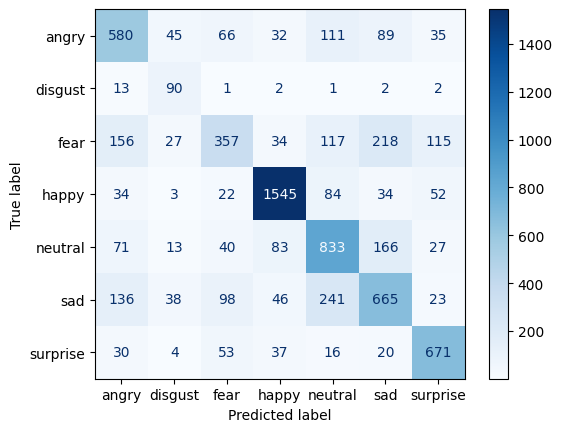

In [12]:
# Confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.show()


## 13. Random Image Prediction and Test Accuracy Display

In this section, we will:

    1.Select a few random test images from the test dataset.
    2.Use the trained model to predict the emotion on each of those images.
    3.Display the image alongside its predicted and true labels.
    4.Calculate and display the overall test accuracy.

Overall Test Accuracy: 66.05%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


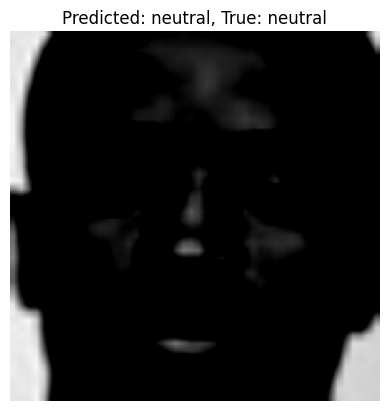

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


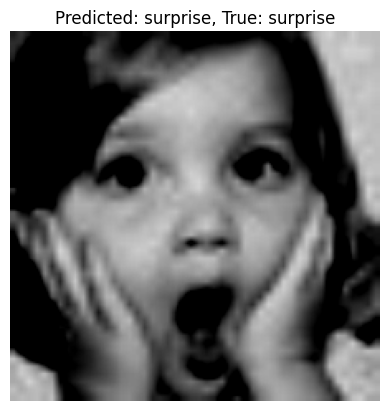

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


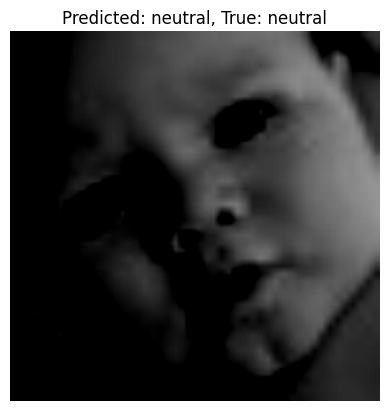

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


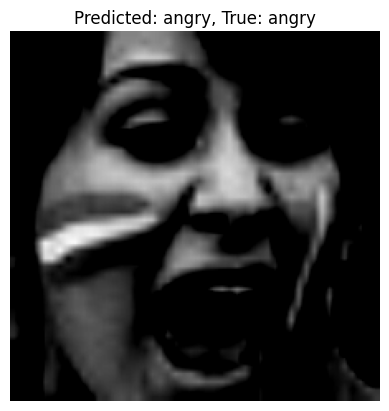

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


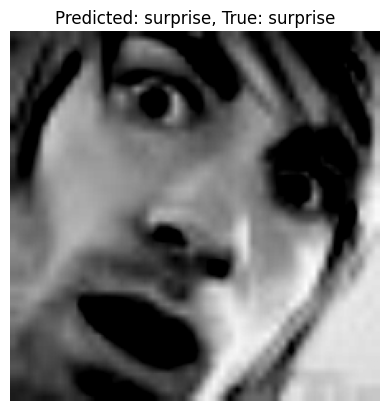

In [20]:
import random
import torch
import matplotlib.pyplot as plt

# Function to calculate overall test accuracy
def calculate_test_accuracy(model, test_loader):
    correct = 0
    total = 0

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device (GPU/CPU)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Total number of images

    accuracy = correct / total  # Overall accuracy
    print(f"Overall Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Function to show random predictions
def show_random_predictions(model, test_dataset, num_images=5):
    model.eval()  # Ensure the model is in evaluation mode
    random_indices = random.sample(range(len(test_dataset)), num_images)  # Get random indices

    for idx in random_indices:
        img, label = test_dataset[idx]  # Get the image and true label
        
        # img is already a tensor, so we don't need to use TF.to_tensor
        img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)  # Get model output
            _, pred = torch.max(output, 1)  # Get predicted class

        pred_label = classes[pred.item()]  # Convert predicted index to class name
        true_label = classes[label]  # Convert true label index to class name
        
        # Convert tensor to numpy for displaying
        img = img.permute(1, 2, 0).cpu().numpy()  # Reorder tensor dimensions to HxWxC (for plt.imshow)

        # Show image and prediction
        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}, True: {true_label}")
        plt.axis('off')  # Turn off axis
        plt.show()

# Calculate overall test accuracy
overall_accuracy = calculate_test_accuracy(model, test_loader)

# Show random predictions on test set
show_random_predictions(model, test_dataset, num_images=5)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_30892\427364760.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_1_state.pth"))
C

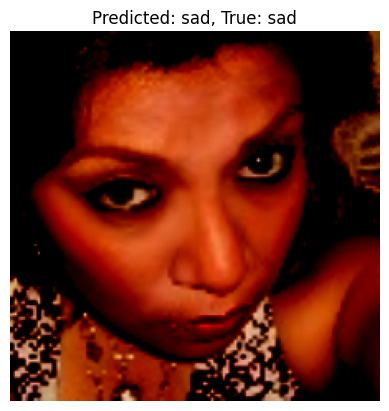

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


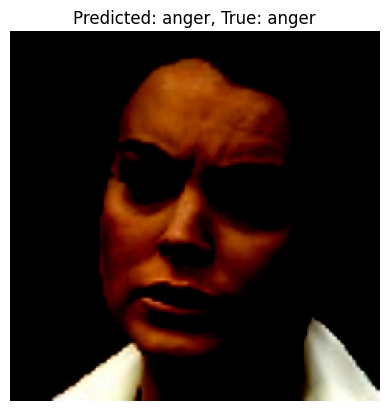

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


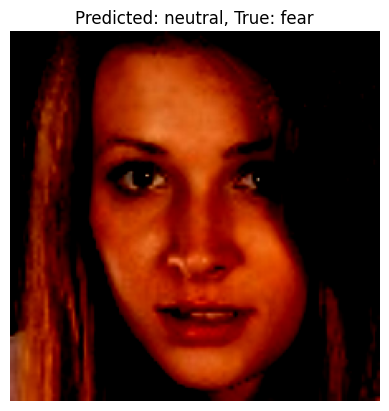

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


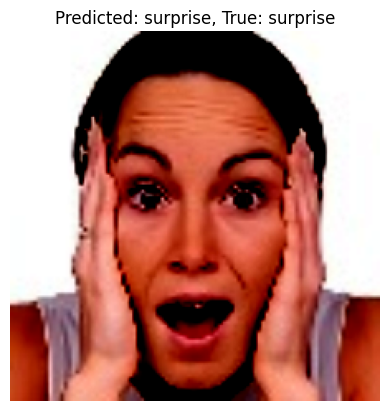

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


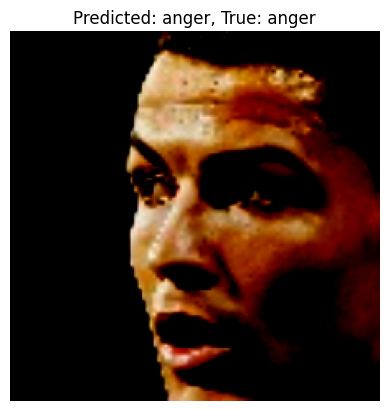

In [4]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import os
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Paths (AffectNet)
train_path = "C:\\Users\\ASUS\\.cache\\kagglehub\\datasets\\noamsegal\\affectnet-training-data\\versions\\train"
test_path = "C:\\Users\\ASUS\\.cache\\kagglehub\\datasets\\noamsegal\\affectnet-training-data\\versions\\val"

# Classes (emotions)
classes = os.listdir(train_path)

# Data transformations (must match what was used during model training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Use the same normalization as the training set
])

# Load AffectNet validation dataset (we will use this for predictions)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the pre-trained model
model = models.efficientnet_b0(pretrained=True)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),  # Added dropout for regularization
    torch.nn.Linear(model.classifier[1].in_features, len(classes))  # Output layer for emotions
)
model = model.to(device)

# Load the pre-trained weights (replace this path with your actual saved model path)
model.load_state_dict(torch.load("best_model_1_state.pth"))
model.eval()

# Function to show random predictions
def show_random_predictions(model, test_dataset, num_images=5):
    random_indices = random.sample(range(len(test_dataset)), num_images)

    for idx in random_indices:
        img, label = test_dataset[idx]
        
        # img is already a tensor, so no need to use TF.to_tensor
        img_tensor = img.unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
        
        pred_label = classes[pred.item()]
        true_label = classes[label]
        
        # Convert tensor to numpy for displaying (unsqueeze batch dimension)
        img = img.permute(1, 2, 0).cpu().numpy()

        # Show image and prediction
        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}, True: {true_label}")
        plt.axis('off')
        plt.show()

# Show random predictions on test set
show_random_predictions(model, test_dataset, num_images=5)


## Attempt Transfer Learning

In [27]:
import torch
import os
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Paths (AffectNet)
train_path = "C:\\Users\\ASUS\\.cache\\kagglehub\\datasets\\noamsegal\\affectnet-training-data\\versions\\train"
test_path = "C:\\Users\\ASUS\\.cache\\kagglehub\\datasets\\noamsegal\\affectnet-training-data\\versions\\val"

# Classes (emotions)
classes = os.listdir(train_path)

# Data transformations (same transformations as in previous training)
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Use the same normalization as the training set
])

# Load AffectNet dataset
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the pre-trained EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Load the pre-trained model weights (ensure this is the path to your previously saved model)
try:
    model.load_state_dict(torch.load('best_model_1_state.pth'), strict=False)
except RuntimeError as e:
    print(f"Error loading model weights: {e}")

# Modify the final classifier layer to match the number of classes in AffectNet (7 emotions)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Dropout layer for regularization
    nn.Linear(model.classifier[1].in_features, len(classes))  # Modify the classifier for AffectNet emotions
)

model = model.to(device)

# Unfreeze the last few layers (or entire classifier) to fine-tune
for param in model.classifier.parameters():
    param.requires_grad = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Function to fine-tune the model
def fine_tune_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    best_val_acc = 0
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = train_correct / total
        train_loss /= total

        model.eval()
        val_loss, val_correct, total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = val_correct / total
        val_loss /= total

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # Save the model if both validation accuracy and loss improve
        if val_loss < best_val_loss and val_acc > best_val_acc:
            print(f"Validation improved. Saving model at epoch {epoch+1}")
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'fine_tuned_model.pth')
            trigger_times = 0  # Reset patience counter
        else:
            trigger_times += 1

        # Early stopping
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return model

# Fine-tune the model with AffectNet dataset
fine_tuned_model = fine_tune_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_57720\4067650842.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_1_state.pth'), 

Error loading model weights: Error(s) in loading state_dict for EfficientNet:
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([7, 1280]) from checkpoint, the shape in current model is torch.Size([1000, 1280]).
	size mismatch for classifier.1.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1000]).
Epoch [1/10], Train Loss: 1.1191, Train Accuracy: 0.5895, Val Loss: 0.9083, Val Accuracy: 0.6564
Validation improved. Saving model at epoch 1
Epoch [2/10], Train Loss: 0.8867, Train Accuracy: 0.6678, Val Loss: 0.8493, Val Accuracy: 0.6819
Validation improved. Saving model at epoch 2
Epoch [3/10], Train Loss: 0.8356, Train Accuracy: 0.6849, Val Loss: 0.8124, Val Accuracy: 0.6898
Validation improved. Saving model at epoch 3
Epoch [4/10], Train Loss: 0.8001, Train Accuracy: 0.6957, Val Loss: 0.8153, Val Accuracy: 0.6873
Epoch [5/10], Train Loss: 0.7756, Train Accuracy: 0.7087, Val Loss: 0.7790, Val Accuracy: